In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline 

In [2]:
class Customer:
    def __init__(self, n, x, y, demand, start, end, service_time):
        self.n = n
        self.x = x
        self.y = y
        self.demand = demand
        self.start = start
        self.end = end
        self.service_time = service_time
                 
    def distance(self, x1, y1):
        return ((self.x - x1)**2 + (self.y- y1) ** 2) ** (1/2)
    
    def delivery_time(self, current, x1, y1):
        arriving_time = current + self.distance(x1, y1)
        if (arriving_time > self.end):
            return -1
        else:
            return max(arriving_time, self.start) + self.service_time
        
        
    def coordinates(self):
        return self.x, self.y

In [3]:
class Route:
    def __init__(self, path, depot, max_capacity):
        self.path = path
        self.depot = depot
        self.max_capacity = max_capacity
        self.distance = self.compute_distance()
        self.capacity = self.compute_capacity()
        self.is_feasible = self.compute_feasible()
        
    def set_path(path):
        self.path = path
        self.distance = self.compute_distance()
        self.capacity = self.compute_capacity()
        
        
    def compute_distance(self):
        distance = 0
        current_point = self.depot
        for point in self.path:
            distance += point.distance(current_point.x, current_point.y)
            current_point = point
        distance += self.depot.distance(current_point.x, current_point.y)
        return distance
     
    def compute_capacity(self):
        capacity = 0
        for point in self.path:
            capacity += point.demand
        return capacity
    
    def compute_feasible(self):
        current_time = 0
        current_point = self.depot
        for point in self.path + [self.depot]:
            delivery = point.delivery_time(current_time, current_point.x, current_point.y)
            if (delivery < 0):
                return False
            current_time = delivery
            current_point = point
        return current_time < self.depot.end and self.capacity <= self.max_capacity
    
    def print_path(self):
        res = ''
        for customer in self.path:
            res += str(customer.n) + " "
        print(res)

In [4]:
class Problem:
    def __init__(self, filename):
        self.name, self.vehicle_constraint, self.capacity_constraint, self.depot, self.customers = self.parse(filename)

        
    def is_feasible(self, routes):
        return (all([any([x in route.path for route in routes]) for x in self.customers])
                and len(routes) < self.vehicle_constraint and all([lambda route: route.is_feasible for route in routes]))
    
    def parse(self, filename):
        name = ''
        n_vehicles = 0
        capacity = 0
        depot = None
        customers = []
        with open(filename) as f:
            for i, line in enumerate(f, 1):
                line = line.replace('\n', '')
                if (i == 1):
                    name = line
                    continue;
                if (i == 5):
                    n_vehicles, capacity = list(map(int, list(filter(None, line.split(' ')))))
                    continue
                if (i == 10 ):
                    depot = self.convert_to_customer(line)
                    continue
                if (i > 10):
                    customers.append(self.convert_to_customer(line))
        return name, n_vehicles, capacity, depot, customers
    
    def convert_to_customer(self, line):
        return Customer(  * list(map(int, list(filter(None, line.replace('\n', '').split(' '))))) )
    
    
    

In [5]:
problem = Problem("instances\\C108.txt")

In [6]:
problem.is_feasible([])

False

In [7]:
class Meta:
    def __init__(self, customer, delivery_time):
        self.customer = customer
        self.delivery_time = delivery_time

In [8]:
class GreedyAlgorithm:
    def __init__(self, problem):
        self.problem = problem
    
    def find_solution():
        pass
    
    def get_path(self, customers):
        current_time = 0
        current_customer = self.problem.depot
        current_state = 0
        flag = False
        path = []
        while (not flag and current_state < self.problem.capacity_constraint):
            metas = list(map(lambda x: Meta(x, x.delivery_time(current_time, current_customer.x, current_customer.y)), customers))
            metas.sort(key = lambda x: x.delivery_time)
            flag = True
            for meta  in metas:
                if (meta.delivery_time < 0):
                    continue
                if (meta.customer.demand <= self.problem.capacity_constraint - current_state 
                    and self.problem.depot.delivery_time(meta.delivery_time, meta.customer.x, meta.customer.y) > 0):
                    current_customer = meta.customer
                    current_time = meta.delivery_time
                    current_state += meta.customer.demand
                    customers.remove(meta.customer)
                    path.append(meta.customer)
                    flag = False
                    break

        return path, current_state, current_time
    
    def get_greedy_routes(self):
        routes = []
        customers_copy = self.problem.customers.copy()
        while (customers_copy):
            routes.append(Route(self.get_path(customers_copy)[0], self.problem.depot, self.problem.capacity_constraint))
        return routes


In [9]:
problem.is_feasible(GreedyAlgorithm(problem).get_greedy_routes())

True

In [10]:
def plot_routes(routes, depot, title):
    fig = plt.figure(figsize=(12,12))
    color=iter(cm.rainbow(np.linspace(0,1,len(routes)+1)))

    ax = fig.add_subplot(111)
    max_x, max_y = 0, 0
    total_distance = 0
    for route in routes:
        total_distance += (route.distance)
        c=next(color)
        verts = [depot.coordinates()]
        for customer in route.path:
            #ax.annotate(str(i), customer.coordinates())
            verts.append(customer.coordinates())
        verts.append(depot.coordinates())
        xs, ys = zip(*verts)
        max_x = max(max_x, max(xs))
        max_y = max(max_y, max(ys))
        ax.plot(xs, ys, 'o-', lw=2, color=c, ms=10)
    ax.set_xlim(-10, max_x + 10)
    ax.set_ylim(-10, max_y + 10)
    ax.text(-9, -20, 'total: '+str(total_distance))
    plt.title(title)

    plt.show()

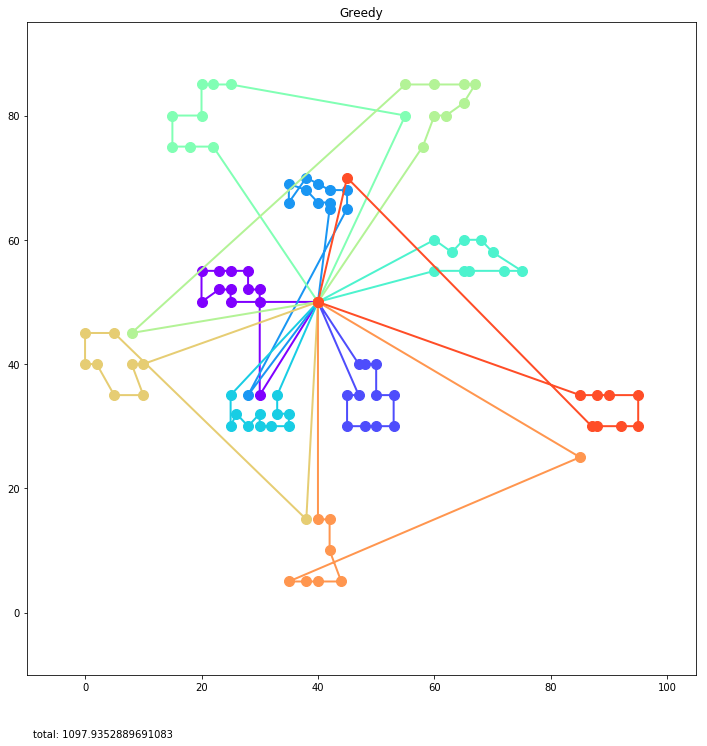

In [11]:
plot_routes(GreedyAlgorithm(problem).get_greedy_routes(), problem.depot,  "Greedy")

In [12]:
class LocalSearch:
    def __init__(self, problem, initial_solution):
        self.problem = problem
        self.initial_solution = initial_solution
    
    def insert_inter(self, route, what_start, what_end, where):
        if (where < what_start):
            return route[:where]+route[what_start:what_end+1]+route[where:what_start] + route[what_end+1:]
        elif (where > what_start):
            return route[:what_start] + route[what_end+1:where] + route[what_start:what_end+1] + route[where:]
        else:
            return route1, route2
        
    def swap_inter(self, route, ind1, ind2, ind3, ind4):
        if (ind1 >= ind2  or ind2 >= ind3 or ind3 >= ind4):
            return route
        return route[:ind1] + route[ind3:ind4+1] + route[ind2+1:ind3] + route[ind1:ind2+1] + route[ind4+1:]
    
    def two_opt_inter(self, route, ind1, ind2):
        return route[:ind1] + [x for x in reversed(route[ind1:ind2+1])] + route[ind2+1:]
    
    def insert_outer(self, route_from, route_to, what_start, what_end, where):
        return route_from[:what_start] + route_from[what_end+1:], route_to[:where] + route_from[what_start: what_end+1] + route_to[where:]

    def swap_outer(self, route1, route2, ind1, ind2, ind3, ind4):
        if (ind1 >= ind2 or ind3>= ind4):
            return route1, route2
        return route1[:ind1] + route2[ind3:ind4+1] + route1[ind2+1:], route2[:ind3] + route1[ind1:ind2+1] + route2[ind4+1:]
    
    def two_opt_outer(self, route1, route2, ind1, ind2):
        if (ind1 == 0 and ind2 == 0):
            return route1, route2
        return route1[:ind1] + route2[ind2:], route2[:ind2] + route1[ind1:]

In [13]:
class IteratedLocalSearch(LocalSearch):
    def __init__(self, problem, initial_solution, epsilon, max_changes_for_perturbation, log_on, plot_on, plot_every):
        LocalSearch.__init__(self, problem, initial_solution)
        self.epsilon = epsilon
        self.max_changes = max_changes_for_perturbation
        self.log_on = log_on
        self.plot_on = plot_on
        self.plot_every = plot_every
        
    def find_solution(self):
        current_solution = self.initial_solution.copy()
        plot_on, plot_every, log_on = self.plot_on, self.plot_every,  self.log_on
        if (plot_on):
            plot_routes(current_solution, self.problem.depot, "Initial solution")
        current_solution = self.local_search(current_solution)
        i = 0
        while (True):
            if (log_on):
                print('Itration', i)
            i += 1
            after_perturbation = self.perturbate(current_solution)
            new_solution = self.local_search(after_perturbation)
            
            if (sum([route.distance for route in current_solution]) - sum([route.distance for route in new_solution]) > self.epsilon ):
                current_solution = new_solution
                if (plot_on and i%plot_every == 0):
                    plot_routes(current_solution, self.problem.depot, "Solution after "+ str(i) + " itereations")
            else:
                break
        if (plot_on):
            plot_routes(current_solution, self.problem.depot, "Final solution")
        
        return current_solution
        
    
    def local_search(self, routes):
        new_routes = routes.copy()
        depot = self.problem.depot
        capacity = self.problem.capacity_constraint
        flag = True
        while (flag):
            flag = False
            for current, route in enumerate(new_routes, 0):
                best = (route, 0, None, None)
                n = len(route.path)
                for i in range(n-1):
                    for j in range(i+1, n):
                        new_route  = Route(self.two_opt_inter(route.path,i, j), depot, capacity)
                        if (new_route.is_feasible and new_route.distance - route.distance < best[1]):
                            best = (new_route, new_route.distance - route.distance,
                                   'Local Search: Neigbor two_opt', [current, i, j] )
                            flag = True
                for i in range(n):
                    for j in range(i, n):
                        for k in range (n):
                            if (k < i or k > j):
                                new_route  = Route(self.insert_inter(route.path,i, j, k), depot, capacity)
                                if (new_route.is_feasible and new_route.distance - route.distance < best[1]):
                                    best = (new_route, new_route.distance - route.distance,
                                           'Local Search: Neigbor insert', [current, i, j, k])
                                    flag = True
                if (n >= 2):
                    for i in range(n-1):
                        for j in range(i, n-1):
                            for k in range (j+1, n):
                                for d in range (k, n):
                                    new_route  = Route(self.swap_inter(route.path,i, j, k, d), depot, capacity)
                                    if (new_route.is_feasible and new_route.distance - route.distance < best[1]):
                                        best = (new_route, new_route.distance - route.distance,
                                               'Local Search: Neigbor swap', [current, i, j, k, d])
                                        flag = True    
                new_routes[current] = best[0]
                if (self.log_on and best[2]):
                    print(best[2], best[3], best[1])
        return list(filter(lambda x: x.path != [], new_routes))
    
    def perturbate(self, routes):
        new_routes = routes.copy()
        depot = self.problem.depot
        capacity = self.problem.capacity_constraint
        counter = 0
        flag = True
        counter = 0
        while( flag ):
            flag = False
            n = len(new_routes)
            for rind1 in range(n):
                for rind2 in range(n):
                    if (rind1 == rind2):
                        continue
                    route2 = new_routes[rind2]
                    route1 = new_routes[rind1]
                    best = (rind1, route1, rind2, route2, -self.epsilon, None, None)
                    n1 = len(route1.path)
                    n2 = len(route2.path)
                    for i in range(n1):
                        for j in range(n2):
                            path1, path2 = self.two_opt_outer(route1.path, route2.path, i, j)
                            new_route1 = Route(path1, depot, capacity)
                            new_route2 = Route(path2, depot, capacity)
                            if (new_route1.is_feasible and new_route2.is_feasible 
                                and new_route1.distance + new_route2.distance - (route1.distance + route2.distance) < best[4] ):
                                best = (rind1, new_route1,
                                        rind2, new_route2, 
                                        new_route1.distance + new_route2.distance - route1.distance - route2.distance,
                                        "Perturbation: Neighbor two opt", [rind1, rind2, i, j])
                                flag = True
                    for i in range(n1):
                        for j in range(i, n1):
                            for k in range(n2):
                                for d in range(k, n2):
                                    path1, path2 = self.swap_outer(route1.path, route2.path, i, j, k, d)
                                    new_route1 = Route(path1, depot, capacity)
                                    new_route2 = Route(path2, depot, capacity)
                                    if (new_route1.is_feasible and new_route2.is_feasible 
                                        and new_route1.distance + new_route2.distance - (route1.distance + route2.distance) < best[4] ):
                                        best = (rind1, new_route1,
                                        rind2, new_route2, 
                                        new_route1.distance + new_route2.distance - route1.distance - route2.distance,
                                               "Perturbation: Neighbor swap", [rind1, rind2, i, j, k, d])
                                        flag = True
                    for i in range(n1):
                        for j in range(i, n1):
                            for k in range(n2):
                                path1, path2 = self.insert_outer(route1.path, route2.path, i, j, k)
                                new_route1 = Route(path1, depot, capacity)
                                new_route2 = Route(path2, depot, capacity)
                                if (new_route1.is_feasible and new_route2.is_feasible 
                                    and new_route1.distance + new_route2.distance - (route1.distance + route2.distance) < best[4]  ):
                                    best = (rind1, new_route1,
                                            rind2, new_route2, 
                                            new_route1.distance + new_route2.distance - route1.distance - route2.distance,
                                            "Perturbation: Neighbor insert", [rind1, rind2, i, j, k])
                                    flag = True


                    new_routes[best[0]] = best[1]
                    new_routes[best[2]] = best[3]
                    if (self.log_on and best[5]):
                        print(best[5], best[6], best[4])
                    if (best[5]):
                        counter += 1
                    if (counter >= self.max_changes):
                        if (self.log_on ):
                            print('Out by counter')
                        return list(filter(lambda x: x.path != [], new_routes))


        return list(filter(lambda x: x.path != [], new_routes))

In [14]:
import os
if not os.path.exists('.\\solutions\\'):
        os.makedirs('.\\solutions\\')

In [15]:
def save_solution(problem, solution):
    filename = ".\\solutions\\" + problem.name + ".sol"
    with open(filename, 'w') as f:
        res = []
        for route in solution:
            s = []
            s.append(str(problem.depot.n))
            s.append(str(problem.depot.start))
            current_time = problem.depot.start
            current_point =problem.depot
            for point in route.path + [problem.depot]:
                current_time = point.delivery_time(current_time, current_point.x, current_point.y)
                current_point = point
                s.append(str(current_point.n))
                s.append(str(current_time - current_point.service_time))
            res.append(" ".join(s))
        f.write("\n".join(res))
        
                
    

In [16]:
def parse_previous_solution(filename_problem, filename_solution):
    problem = Problem(filename_problem)
    solution = []
    with open(filename_solution) as f:
        sf = f.read()
        str_routes = sf.split('\n')
        for str_route in str_routes:
            path = []
            for customer in str_route.split(" ")[2:-3:2]:
                path.append(problem.customers[int(customer) - 1])
            solution.append(Route(path, problem.depot, problem.capacity_constraint))
        if (not any(any(1 == customer.n for customer in route.path) for route in solution)):
            solution.append(Route([problem.customers[0]], problem.depot, problem.capacity_constraint))
    return(problem, solution)

In [17]:
def apply_itl(filename):
    problem = Problem(filename)
    greedy_solution = GreedyAlgorithm(problem).get_greedy_routes()
    itl = IteratedLocalSearch(problem, greedy_solution, 0.001, 10, True, True, 5)
    solution = itl.find_solution()
    save_solution(problem, solution)
    return (problem, solution)

In [18]:
def apply_itl_with_previous(filename_problem, filename_solution):
    problem, initial = parse_previous_solution(filename_problem, filename_solution)
    itl = IteratedLocalSearch(problem, initial, 0.001, 10, True, True, 2)
    solution = itl.find_solution()
    save_solution(problem, solution)
    return (problem, solution)

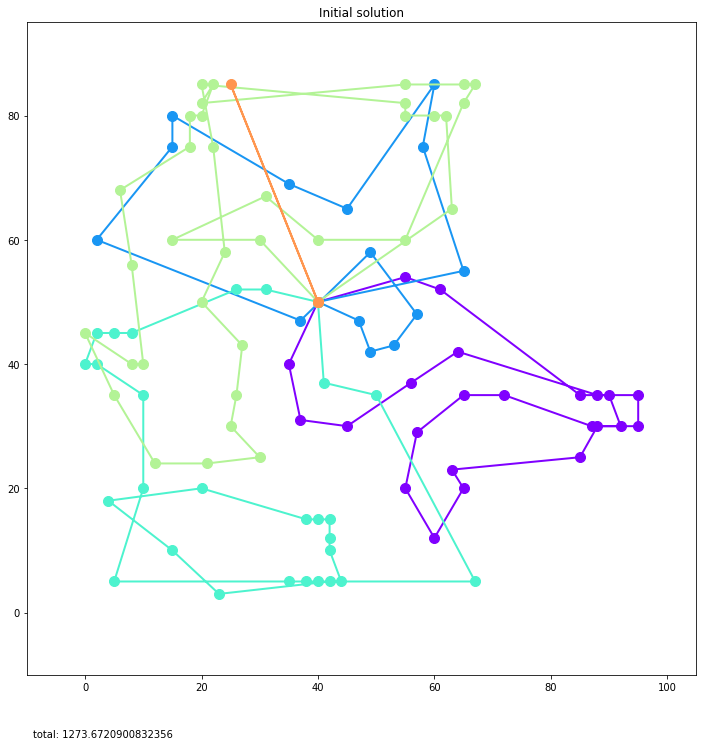

Itration 0
Perturbation: Neighbor insert [0, 4, 0, 22, 0] -10.463731005333557
Perturbation: Neighbor two opt [3, 4, 30, 23] -21.193058927172046
Perturbation: Neighbor swap [4, 3, 0, 24, 0, 30] -20.50695381930052
Perturbation: Neighbor swap [3, 4, 0, 23, 0, 33] -1.1143792464110334
Local Search: Neigbor insert [2, 26, 29, 31] -21.22158409480471
Itration 1
Perturbation: Neighbor insert [0, 2, 4, 4, 31] -0.04884132137959796
Perturbation: Neighbor insert [2, 0, 0, 0, 1] -5.101447524120886


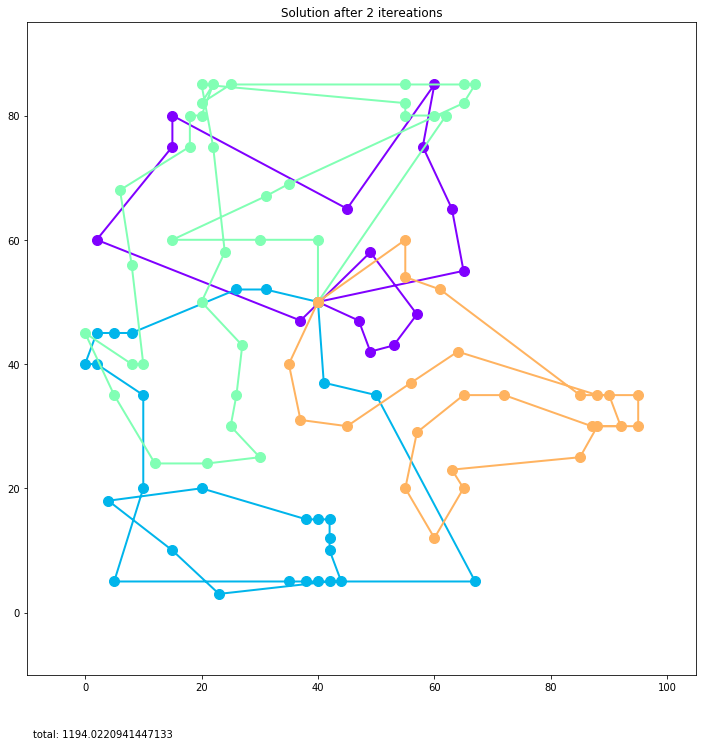

Itration 2


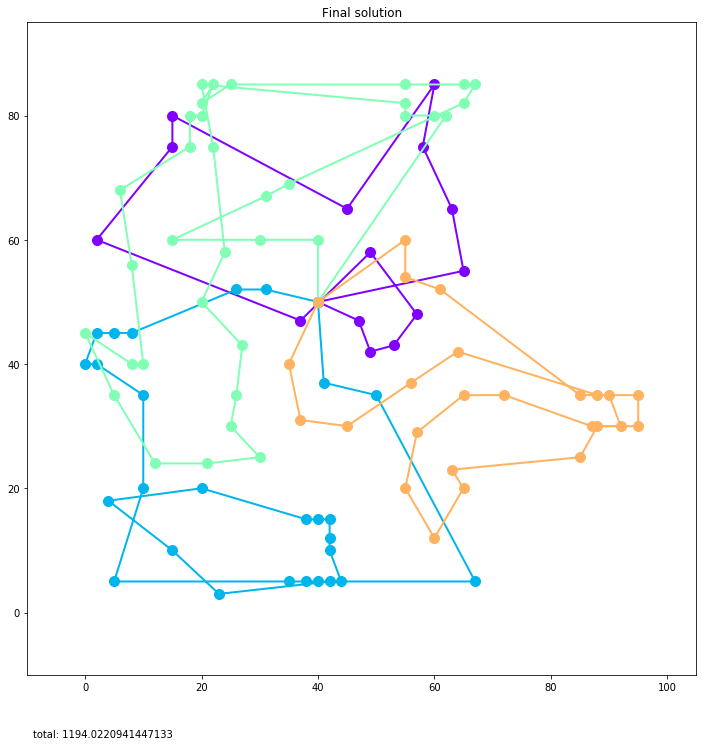

In [21]:
problem207, solution207 = apply_itl_with_previous('instances\\RC207.txt', 'solutions\\RC207.sol')

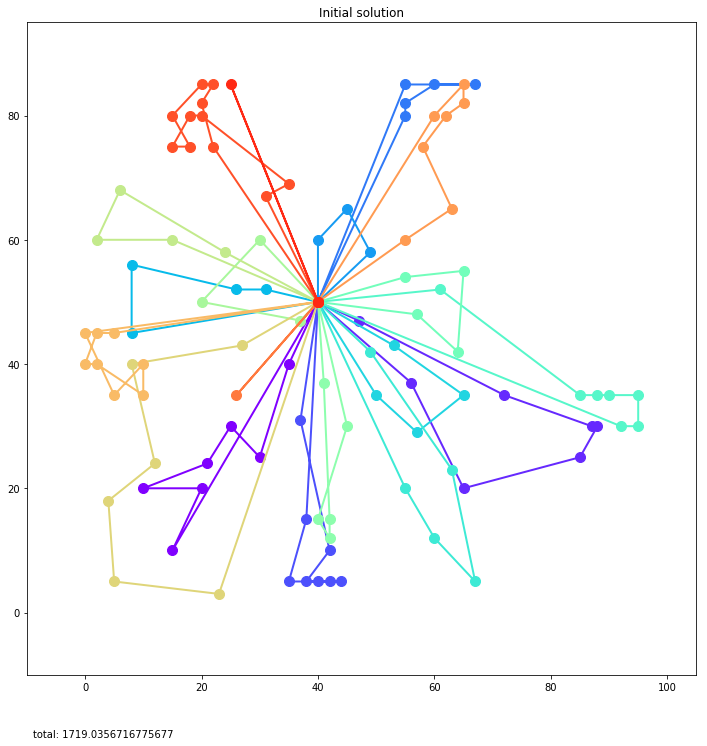

Itration 0
Perturbation: Neighbor insert [4, 18, 0, 2, 0] -18.92410605509305
Perturbation: Neighbor insert [5, 13, 3, 3, 1] -5.961039176332406
Perturbation: Neighbor swap [5, 18, 0, 2, 0, 2] -18.096928038482673
Perturbation: Neighbor insert [8, 9, 6, 6, 3] -1.7970608476929186
Perturbation: Neighbor two opt [12, 18, 2, 3] -9.853544419050493
Perturbation: Neighbor insert [17, 12, 6, 8, 2] -10.595594365525415
Perturbation: Neighbor swap [12, 17, 0, 5, 0, 6] -3.9304528189203296
Perturbation: Neighbor two opt [17, 12, 6, 6] -2.8691225517432883
Perturbation: Neighbor insert [12, 17, 2, 2, 5] -1.2914542801949551
Itration 1


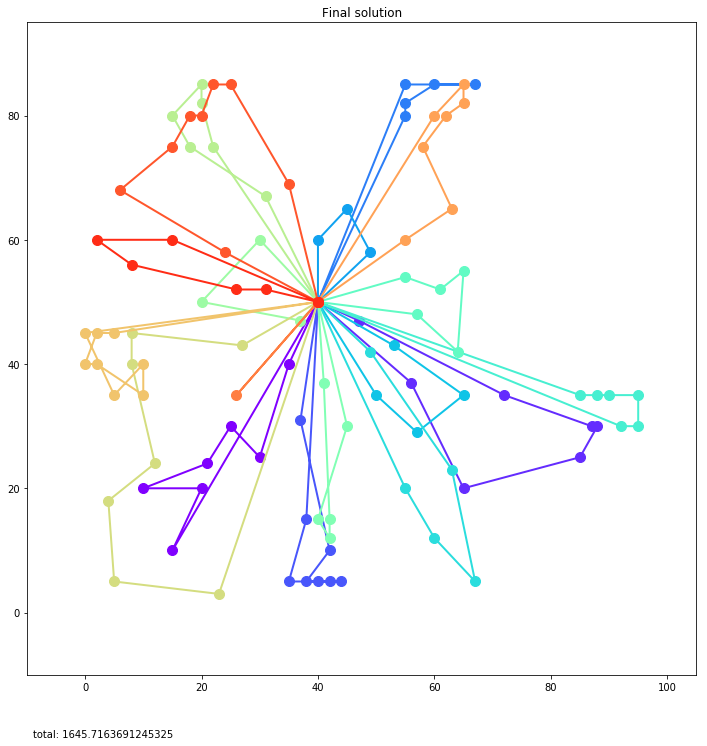

In [22]:
problem105, solution105 = apply_itl_with_previous('instances\\RC105.txt', 'solutions\\RC105.sol')

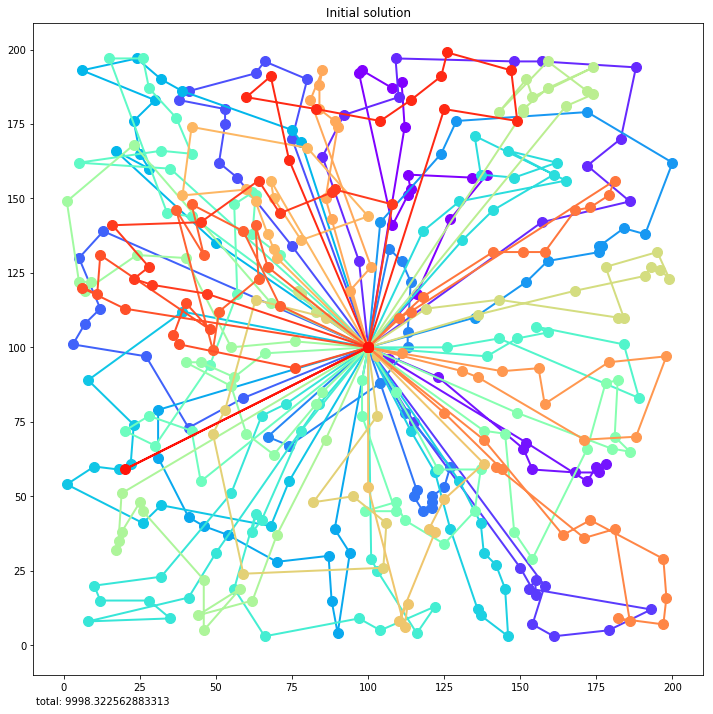

Itration 0
Perturbation: Neighbor two opt [5, 38, 2, 0] -19.378793692096792
Perturbation: Neighbor insert [7, 5, 6, 7, 2] -11.996528169645472
Perturbation: Neighbor swap [7, 15, 0, 4, 0, 11] -7.080312584582202
Perturbation: Neighbor swap [7, 19, 0, 11, 0, 10] -6.581591205108367
Perturbation: Neighbor swap [9, 5, 0, 9, 0, 3] -15.457423003310026
Perturbation: Neighbor two opt [9, 18, 1, 5] -24.954908488904266
Perturbation: Neighbor two opt [9, 38, 1, 0] -1.3444593101798432
Perturbation: Neighbor insert [11, 9, 9, 9, 2] -9.298187303761836
Perturbation: Neighbor insert [14, 18, 10, 10, 0] -1.265768435674147
Perturbation: Neighbor insert [15, 25, 0, 4, 0] -2.1266029062573537
Out by counter
Itration 1
Perturbation: Neighbor swap [5, 17, 9, 10, 7, 8] -60.533854727010635
Perturbation: Neighbor insert [7, 5, 1, 1, 0] -0.32951447806630085
Perturbation: Neighbor insert [11, 17, 6, 7, 9] -2.6965020076896167
Perturbation: Neighbor swap [11, 33, 0, 7, 0, 8] -1.2513169302591223
Perturbation: Neighbor

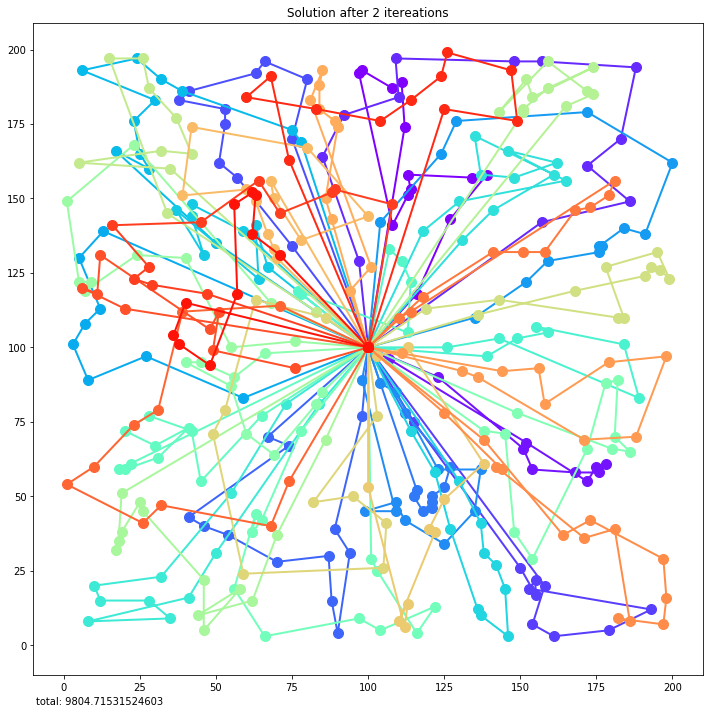

Itration 2
Perturbation: Neighbor swap [1, 27, 0, 9, 1, 9] -1.330558816462343
Perturbation: Neighbor two opt [6, 27, 0, 1] -0.14587982310288794
Perturbation: Neighbor insert [10, 11, 11, 11, 3] -0.2670798583333749
Perturbation: Neighbor swap [10, 24, 7, 10, 2, 7] -2.6869407335942697
Perturbation: Neighbor two opt [11, 24, 7, 7] -2.5226037098668144
Perturbation: Neighbor two opt [11, 26, 7, 8] -10.738944047301459
Perturbation: Neighbor swap [11, 37, 2, 6, 0, 4] -46.57309906028701
Perturbation: Neighbor swap [14, 17, 0, 9, 0, 10] -0.8827892784345863
Perturbation: Neighbor swap [16, 26, 0, 5, 0, 7] -13.73514666821768
Perturbation: Neighbor swap [17, 18, 0, 9, 0, 10] -0.3367737399085513
Out by counter
Local Search: Neigbor insert [10, 6, 12, 4] -17.09204255846629
Local Search: Neigbor insert [14, 0, 0, 11] -0.5064014610137519
Local Search: Neigbor insert [18, 1, 10, 0] -0.04569806337093496
Local Search: Neigbor insert [24, 8, 8, 0] -0.5178557893632387
Local Search: Neigbor insert [37, 2, 3

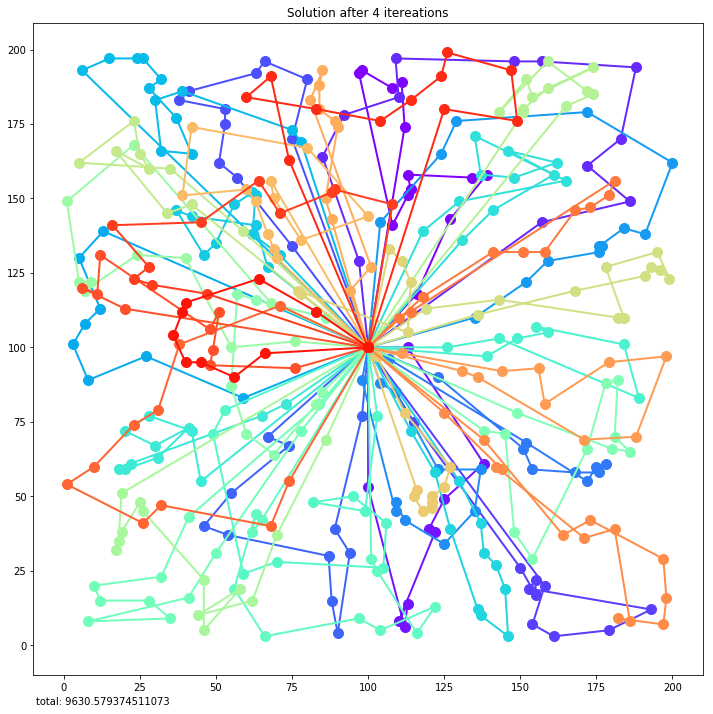

Itration 4
Perturbation: Neighbor insert [22, 33, 12, 12, 4] -3.7847529224146115
Perturbation: Neighbor insert [33, 9, 9, 9, 1] -0.9695245100411398
Perturbation: Neighbor swap [33, 26, 0, 8, 0, 5] -1.388920441450665
Perturbation: Neighbor insert [34, 37, 5, 5, 2] -9.657163223029073
Perturbation: Neighbor insert [18, 26, 9, 9, 2] -1.0782391900500556
Perturbation: Neighbor insert [5, 18, 8, 8, 9] -0.09158884531166223
Itration 5


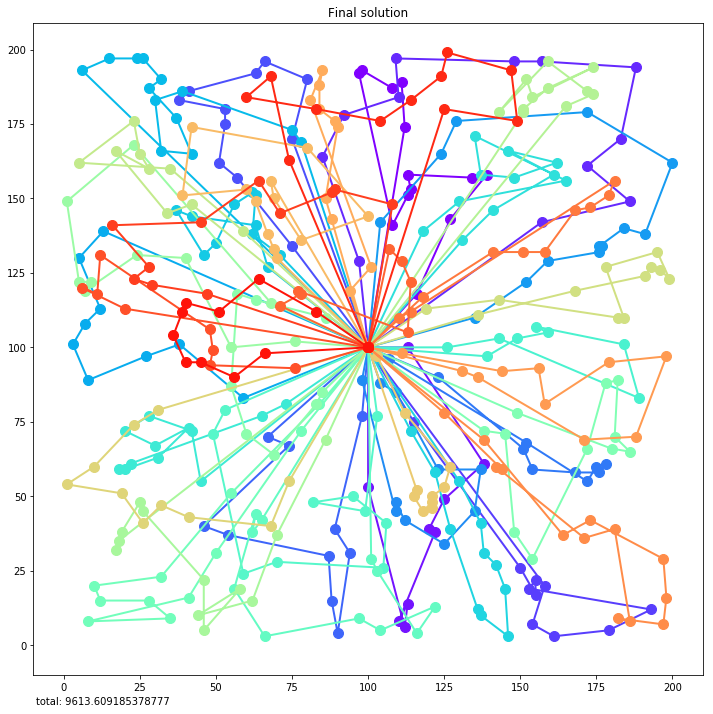

In [24]:
problem146, solution146 = apply_itl_with_previous('instances\\R146.txt', 'solutions\\r1_4_6.sol')